# Iteratively running random forest on WA HUC units using subsets of training data and raster stacks from full WA state

In [113]:
library(terra)
library(tidyterra)
library(dplyr)
library(randomForest)
library(caret)
set.seed(11)


Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


Loading required package: lattice



In [114]:
wa_shp <- vect("data/wa_shp_diss.gpkg")
wa_hucs <- vect("data/Hydrography/WA_HUC8.gpkg")

In [115]:
datapath <- paste0(getwd(), "/data/huc_data")
datapath

[1] "/home/ajs0428/WIP Testing/data/huc_data"

In [116]:
gsub(" ", "", paste0(wa_hucs$name[[1]]))


[1] "WillapaBay"

In [117]:
list_rasts <- as.list(list.files(path = datapath, 
                                 full.names = TRUE, 
                                 pattern = "Skykomish",
                                 include.dirs = FALSE))
list_rasts

list_pts <- as.list(list.files(path = paste0(datapath, "/points"), 
                                 full.names = TRUE, 
                                 pattern = "Skykomish",
                                 include.dirs = FALSE))
list_pts

[[1]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/clim_stackSkykomish.tif"

[[2]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/terr_stackSkykomish.tif"

[[3]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/wa_specSkykomish.tif"

[[1]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/points/Skykomish_pts.gpkg"

In [118]:
terr_rast <- (list_rasts[grep('terr', (list_rasts))])[[1]]
(terr_rast)

deparse(substitute(terr_rast))

[1] "/home/ajs0428/WIP Testing/data/huc_data/terr_stackSkykomish.tif"

[1] "terr_rast"

In [119]:
wip_rf_func <- function(hucs, path) {
    for(i in 1:length(hucs)){
        rasts <- as.list(list.files(path = path, 
                                     full.names = TRUE, 
                                     pattern = gsub(" ", "", paste0(hucs$name[[i]])),
                                     include.dirs = FALSE))
    
        pts <- as.list(list.files(path = paste0(path, "/points"), 
                                     full.names = TRUE, 
                                     pattern = gsub(" ", "", paste0(hucs$name[[i]])),
                                     include.dirs = FALSE))
      
        training_pts <- vect(pts[[1]])
        terr_rast <- rast((rasts[grep('terr', (rasts))])[[1]])
        spec_rast <- rast((rasts[grep('spec', (rasts))])[[1]])
        clim_rast <- rast((rasts[grep('clim', (rasts))])[[1]])
        
        pts_ext <-  training_pts |>
                terra::extract(x = terr_rast, bind = T) |> 
                terra::extract(x = spec_rast, bind = T) |> 
                terra::extract(x = clim_rast, bind = T) |> 
                as.data.frame() |> 
                dplyr::mutate(class = as.factor(class)) |>
                na.exclude() |>
                write.csv(paste0(path, "/RF_Models/", 
                                 gsub(" ", "", paste0(hucs$name[[i]])), "rf_df", ".csv"))
        
        pts_ext <- read.csv(paste0(path, "/RF_Models/", 
                                 gsub(" ", "", paste0(hucs$name[[i]])), "rf_df", ".csv"),
                            stringsAsFactors = T) |>
                    select(-X)

        train.index <- as.vector(sample(c(1:nrow(pts_ext)), 0.7*nrow(pts_ext), replace=F))
        train <- pts_ext[train.index, ]
        test <- pts_ext[-train.index, ]

        rf_model <- randomForest(as.factor(class) ~ ., mtry = 10, 
                         sampsize = nrow(train[train$class == "WET",]),
                         replace = TRUE, #weights = wetwt, 
                         nodesize =1,
                         ntree = 1000, na.action = na.omit,
                         importance = TRUE, data = train)
        
        test_predict <- predict(rf_model, newdata = test, type = "response") 
        cm <- caret::confusionMatrix(test_predict, as.factor(test$class))
        
        cmtocsv <- data.frame(cbind(t(cm$overall),t(cm$byClass)))
        write.csv(cmtocsv,file=paste0(path, "/RF_Models/",
                                          gsub(" ", "", paste0(hucs$name[[i]])), "rf_model_testCM", ".csv"))
        
        save(rf_model, file = paste0(path, "/RF_Models/",
                                          gsub(" ", "", paste0(hucs$name[[i]])), "rf_model", ".RData"))
        
        
    }
}


In [120]:
(read.csv("data/huc_data/RF_Models/WillapaBayrf_df.csv")) |> select(-X)

class,NASADEM_HGT_n49w125,wa_dev27,wa_dev3,wa_dev81,wa_dinfsca,wa_planc,wa_profc,wa_rugged,wa_slope,wa_twi,tree_canopy_cover,NDVI_median,MNDWI_median,EVI_median,SAVI_median,NDYI_median,PRISM_ppt_30yr_normal_800mM4_annual_asc,PRISM_tmean_30yr_normal_800mM4_annual_asc,PRISM_vpdmax_30yr_normal_800mM5_annual_asc
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UPL,133.61749,-0.448040277,0.19003369,-0.10893796,23.64304,-38.921513,-5.4683523,1.4579096,3.9171553,5.844370,58,0.9066304,-0.4665410,0.5598455,0.5354946,0.4637725,2244.611,9.544688,8.143576
UPL,155.20795,0.283215314,-0.03954102,0.08954266,42.30442,34.893261,0.1698989,10.3180866,27.1091290,4.414465,58,0.9055085,-0.5126817,0.6726913,0.6137024,0.4106536,2039.214,10.140944,8.966765
UPL,68.80382,0.236647010,-0.01541678,0.76339841,23.64304,27.640148,3.2159915,1.3018215,3.2960603,6.017464,61,0.8884072,-0.4432457,0.5422187,0.5195574,0.4252861,2121.223,10.415134,6.795833
UPL,32.91496,-0.120091982,-0.04649486,-0.09224981,72.85970,66.251053,-7.1380959,4.3396287,11.9590702,5.840601,71,0.8774161,-0.4258616,0.5184364,0.4993690,0.4277071,2089.159,10.507970,6.645146
UPL,22.90202,0.321765453,-0.29542065,1.16392243,89.44859,54.192123,5.2654095,0.8310365,2.1920457,7.756568,67,0.8282877,-0.4125210,0.4203092,0.4080107,0.2758917,1929.628,10.383741,5.549780
UPL,256.57687,-0.309701890,-0.49268711,-0.23131222,309.67090,153.939667,11.5871830,2.6753097,6.3780303,7.926735,57,0.8722496,-0.5633449,0.5910003,0.5511211,0.3923204,2151.212,9.730947,8.968331
UPL,151.17870,0.327484548,0.38052917,0.74337298,47.28609,-179.600876,-6.5610490,3.2281992,8.0087433,5.817367,55,0.9094237,-0.4819886,0.6323696,0.5843077,0.4121353,2154.360,9.861394,7.962495
UPL,116.61768,-0.219294921,-0.09542012,-0.13739616,95.91204,-40.148834,15.1597271,3.4367521,9.1677504,6.387381,65,0.8802097,-0.4592847,0.5131344,0.4975280,0.4035520,2347.451,10.169700,8.382439
UPL,133.21484,0.496566951,0.39702713,0.97854477,338.70337,-191.009308,-8.6069202,2.5426164,6.2305126,8.039941,50,0.9144223,-0.4717989,0.6952219,0.6305297,0.4334228,2275.680,9.886416,7.745292


In [86]:
#wip_rf_func(wa_hucs, datapath)

ERROR: Error in randomForest.default(m, y, ...): Need at least two classes to do classification.


In [121]:
test <- get(load("data/huc_data/RF_Models/WillapaBayrf_model.RData"))

In [122]:
test$importance

,UPL,WET,MeanDecreaseAccuracy,MeanDecreaseGini
NASADEM_HGT_n49w125,0.1002631975,0.3188382592,0.1596982278,459.18111
wa_dev27,0.0142798008,0.0173829764,0.0151229424,45.70231
wa_dev3,0.0043111442,0.0015163093,0.0035499356,20.12409
wa_dev81,0.0225123058,0.0611261281,0.0330131763,91.24544
wa_dinfsca,0.0001342427,0.0011894270,0.0004209791,10.47788
wa_planc,0.0023218519,-0.0003667533,0.0015906154,20.08155
wa_profc,0.0002654276,0.0082915619,0.0024466569,23.42050
wa_rugged,0.0128132212,0.0236382001,0.0157540597,67.69128
wa_slope,0.0110536107,0.0293899900,0.0160443028,48.82780
wa_twi,0.0026412402,0.0131051087,0.0054862797,18.04212


Combine all test confusion matrix dataframes and compare accuracies

In [91]:
read.csv("data/huc_data/RF_Models/WillapaBayrf_model_testCM.csv") 

X,Accuracy,Kappa,AccuracyLower,AccuracyUpper,AccuracyNull,AccuracyPValue,McnemarPValue,Sensitivity,Specificity,Pos.Pred.Value,Neg.Pred.Value,Precision,Recall,F1,Prevalence,Detection.Rate,Detection.Prevalence,Balanced.Accuracy
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9199668,0.7910422,0.9119483,0.9274725,0.7402032,7.738717e-224,0.4451772,0.9481793,0.839585,0.9439487,0.8504446,0.9439487,0.9481793,0.9460593,0.7402032,0.7018453,0.7435206,0.8938821


## Visualize the accuracy results for each model

In [124]:
list_testacc <- as.list(list.files(path = paste0(datapath, "/RF_Models"), 
                                 full.names = TRUE, 
                                 pattern = "CM.csv",
                                 include.dirs = FALSE))

list_testacc

[[1]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/BanksLakerf_model_testCM.csv"

[[2]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/ChiefJosephrf_model_testCM.csv"

[[3]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Colvillerf_model_testCM.csv"

[[4]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Duwamishrf_model_testCM.csv"

[[5]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/GraysHarborrf_model_testCM.csv"

[[6]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Hangmanrf_model_testCM.csv"

[[7]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Hoh-Quillayuterf_model_testCM.csv"

[[8]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Klickitatrf_model_testCM.csv"

[[9]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LakeChelanrf_model_testCM.csv"

[[10]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LakeWashingtonrf_model_testCM.csv"

[[11]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LittleSpokanerf_model_testCM.csv"

[[12]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LowerChehalisrf_model_testCM.csv"

[[13]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LowerCrabrf_model_testCM.csv"

[[14]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LowerGrandeRonderf_model_testCM.csv"

[[15]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LowerSkagitrf_model_testCM.csv"

[[16]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/LowerSnake-Asotinrf_model_testCM.csv"

[[17]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Methowrf_model_testCM.csv"

[[18]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/MiddleColumbia-LakeWallularf_model_testCM.csv"

[[19]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/MosesCouleerf_model_testCM.csv"

[[20]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Nisquallyrf_model_testCM.csv"

[[21]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Nooksackrf_model_testCM.csv"

[[22]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Palouserf_model_testCM.csv"

[[23]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/PugetSoundrf_model_testCM.csv"

[[24]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Puyalluprf_model_testCM.csv"

[[25]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Queets-Quinaultrf_model_testCM.csv"

[[26]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Rockrf_model_testCM.csv"

[[27]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Sanpoilrf_model_testCM.csv"

[[28]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Saukrf_model_testCM.csv"

[[29]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Skykomishrf_model_testCM.csv"

[[30]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Snohomishrf_model_testCM.csv"

[[31]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Stillaguamishrf_model_testCM.csv"

[[32]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/SumasRiverrf_model_testCM.csv"

[[33]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/UpperColumbia-Entiatrf_model_testCM.csv"

[[34]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/UpperCrabrf_model_testCM.csv"

[[35]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/UpperSkagitrf_model_testCM.csv"

[[36]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/WallaWallarf_model_testCM.csv"

[[37]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/Wenatcheerf_model_testCM.csv"

[[38]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/RF_Models/WillapaBayrf_model_testCM.csv"

In [125]:
empty <- list()
for(i in 1:length(list_testacc)){
    csv <- read.csv(list_testacc[[i]])
    csv$X <- substr(list_testacc[[i]], 51, 60)
    empty[[i]] <- csv
}

In [126]:
testacc <- bind_rows(empty)
testacc

X,Accuracy,Kappa,AccuracyLower,AccuracyUpper,AccuracyNull,AccuracyPValue,McnemarPValue,Sensitivity,Specificity,Pos.Pred.Value,Neg.Pred.Value,Precision,Recall,F1,Prevalence,Detection.Rate,Detection.Prevalence,Balanced.Accuracy
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BanksLaker,0.9605374,0.6051966,0.9519224,0.9679947,0.9315701,1.035719e-09,1.028686e-14,0.9959441,0.4785276,0.9629630,0.8965517,0.9629630,0.9959441,0.9791759,0.9315701,0.9277918,0.9634761,0.7372359
ChiefJosep,0.9441784,0.7805233,0.9380959,0.9498284,0.8437655,2.622320e-130,1.053849e-05,0.9749462,0.7780127,0.9595454,0.8518519,0.9595454,0.9749462,0.9671845,0.8437655,0.8226259,0.8573080,0.8764794
Colvillerf,0.9437934,0.8477297,0.9370706,0.9499957,0.7563059,5.231164e-279,8.120554e-01,0.9621849,0.8867156,0.9634499,0.8831169,0.9634499,0.9621849,0.9628170,0.7563059,0.7277061,0.7553128,0.9244502
Duwamishrf,0.9034797,0.7174895,0.8909981,0.9149720,0.7738194,1.182493e-62,1.835200e-02,0.9475375,0.7527473,0.9291339,0.8074656,0.9291339,0.9475375,0.9382454,0.7738194,0.7332229,0.7891466,0.8501424
GraysHarbo,0.8783090,0.6711220,0.8649355,0.8908000,0.7305413,1.188102e-73,1.975301e-13,0.9518659,0.6788856,0.8893380,0.8387681,0.8893380,0.9518659,0.9195402,0.7305413,0.6953773,0.7819044,0.8153758
Hangmanrf_,0.9222077,0.7877870,0.9105003,0.9328260,0.7461973,2.351683e-105,2.843681e-05,0.9644729,0.7979452,0.9334837,0.8842505,0.9334837,0.9644729,0.9487253,0.7461973,0.7196871,0.7709691,0.8812091
Hoh-Quilla,0.8956841,0.6513291,0.8874746,0.9034876,0.8041237,6.539836e-79,1.384797e-09,0.9513255,0.6672614,0.9214902,0.7695473,0.9214902,0.9513255,0.9361702,0.8041237,0.7649834,0.8301590,0.8092934
Klickitatr,0.9165961,0.7671293,0.9099151,0.9229320,0.7507762,2.695856e-284,1.452845e-20,0.9657895,0.7684032,0.9262665,0.8817414,0.9262665,0.9657895,0.9456152,0.7507762,0.7250917,0.7828112,0.8670963
LakeChelan,0.9816316,0.7697458,0.9767710,0.9857087,0.9540789,1.065719e-19,1.703879e-04,0.9949037,0.7058824,0.9859708,0.8695652,0.9859708,0.9949037,0.9904171,0.9540789,0.9492166,0.9627229,0.8503930


## Now we can try to generate a prediction in one of the watersheds

To do this we need a raster stack of the covariates in the same resolution and projection. Preferably in the resolution of the DEM used to make terrain metrics

In [137]:
wa_hucs$name[wa_hucs$name == "Colville"]

[1] "Colville"

In [139]:
pred_rasts <- as.list(list.files(path = datapath, 
                                     full.names = TRUE, 
                                     pattern = gsub(" ", "", paste0("Colville")),
                                     include.dirs = FALSE))
pred_rasts

[[1]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/clim_stackColville.tif"

[[2]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/terr_stackColville.tif"

[[3]]
[1] "/home/ajs0428/WIP Testing/data/huc_data/wa_specColville.tif"

In [140]:
pred_terr <- rast((pred_rasts[grep('terr', (pred_rasts))])[[1]])
pred_spec <- rast((pred_rasts[grep('spec', (pred_rasts))])[[1]]) |> resample(pred_terr)
pred_clim <- rast((pred_rasts[grep('clim', (pred_rasts))])[[1]]) |> resample(pred_terr)


pred_terr
pred_spec

class       : SpatRaster 
dimensions  : 16959, 25378, 10  (nrow, ncol, nlyr)
resolution  : 23.64304, 23.64304  (x, y)
extent      : 371131.6, 971144.8, 5043580, 5444542  (xmin, xmax, ymin, ymax)
coord. ref. : NAD83(HARN) / UTM zone 10N (EPSG:3740) 
source      : terr_stackColville.tif 
names       : NASAD~9w125,  wa_dev27,   wa_dev3,  wa_dev81, wa_dinfsca, wa_planc, ... 
min values  :    380.2016, -5.599508, -2.665802, -3.057781,   23.64304, -88629.5, ... 
max values  :   2042.1582,  4.350644,  2.708910,  4.749399, 6475.43359, 124696.0, ... 

class       : SpatRaster 
dimensions  : 16959, 25378, 6  (nrow, ncol, nlyr)
resolution  : 23.64304, 23.64304  (x, y)
extent      : 371131.6, 971144.8, 5043580, 5444542  (xmin, xmax, ymin, ymax)
coord. ref. : NAD83(HARN) / UTM zone 10N (EPSG:3740) 
source      : spat_a6abe395a5372_682686.tif 
names       : tree_~cover, NDVI_median, MNDWI_median,  EVI_median, SAVI_median, NDYI_median 
min values  :           0,  -0.5524498,   -0.6783906, -0.06902969, -0.08062372,  -0.1635109 
max values  :          77,   0.9154508,    0.7987719,  0.80645883,  0.70562333,   0.7686263 

In [163]:
pred_stack <- c(pred_terr, pred_spec, pred_clim)
names(pred_stack)

[1] "NASADEM_HGT_n49w125"                       
 [2] "wa_dev27"                                  
 [3] "wa_dev3"                                   
 [4] "wa_dev81"                                  
 [5] "wa_dinfsca"                                
 [6] "wa_planc"                                  
 [7] "wa_profc"                                  
 [8] "wa_rugged"                                 
 [9] "wa_slope"                                  
[10] "wa_twi"                                    
[11] "tree_canopy_cover"                         
[12] "NDVI_median"                               
[13] "MNDWI_median"                              
[14] "EVI_median"                                
[15] "SAVI_median"                               
[16] "NDYI_median"                               
[17] "PRISM_ppt_30yr_normal_800mM4_annual_asc"   
[18] "PRISM_tmean_30yr_normal_800mM4_annual_asc" 
[19] "PRISM_vpdmax_30yr_normal_800mM5_annual_asc"

X,Accuracy,Kappa,AccuracyLower,AccuracyUpper,AccuracyNull,AccuracyPValue,McnemarPValue,Sensitivity,Specificity,Pos.Pred.Value,Neg.Pred.Value,Precision,Recall,F1,Prevalence,Detection.Rate,Detection.Prevalence,Balanced.Accuracy
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9437934,0.8477297,0.9370706,0.9499957,0.7563059,5.231164e-279,0.8120554,0.9621849,0.8867156,0.9634499,0.8831169,0.9634499,0.9621849,0.962817,0.7563059,0.7277061,0.7553128,0.9244502


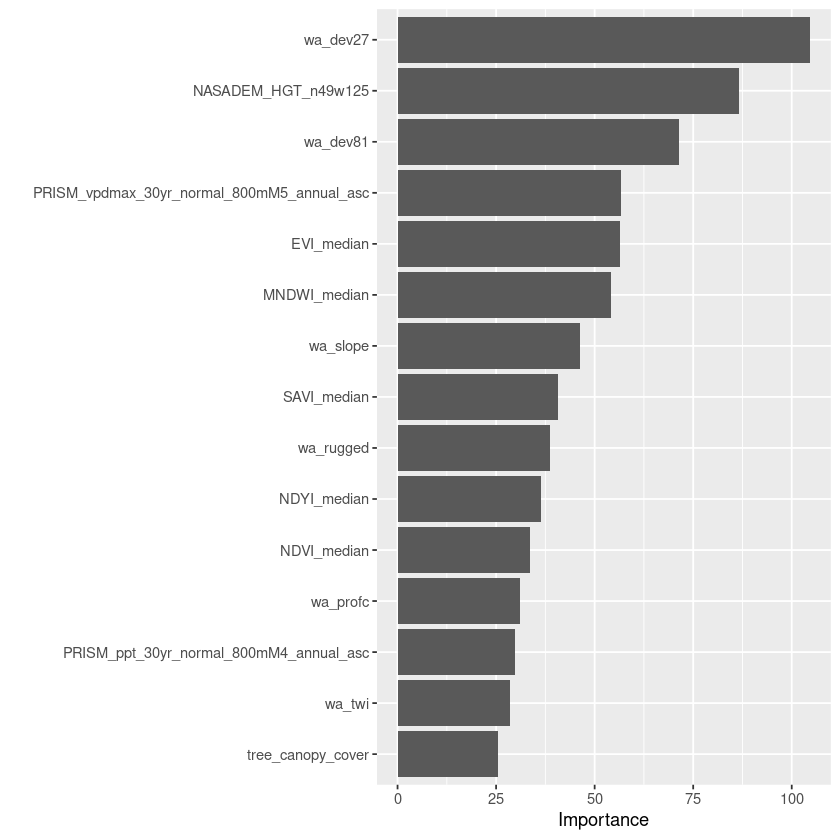

In [164]:
list_models <- as.list(list.files(path = paste0(datapath, "/RF_Models"), 
                                 full.names = TRUE, 
                                 pattern = "Colvillerf_model",
                                 include.dirs = FALSE))
#list_models
read.csv(list_models[[1]])
pred_model <- get(load(list_models[[2]]))
vip::vip(pred_model, num_features = 15)

In [147]:
pred_wip <- predict(pred_stack, pred_model, type = "prob", 
                    filename = "data/huc_data/WIPs/ColvilleWIP.tif", 
                    overwrite = TRUE)

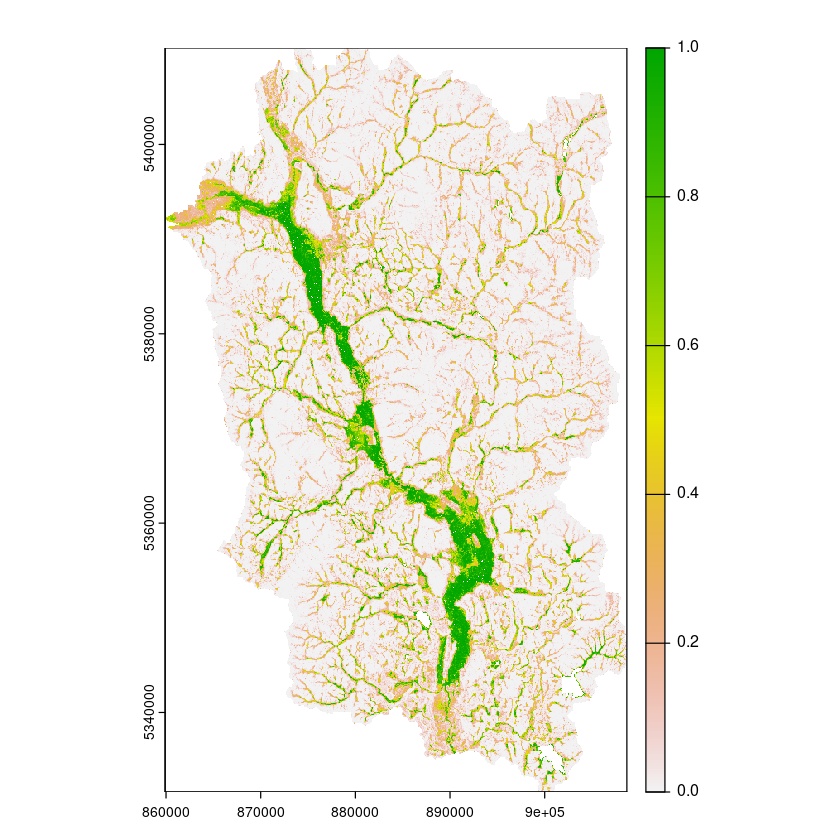

In [173]:
plot(pred_wip[[2]], ext = ext(vect("data/huc_data/points/Colville_pts.gpkg")))

It looks like there is an issue with the TWI

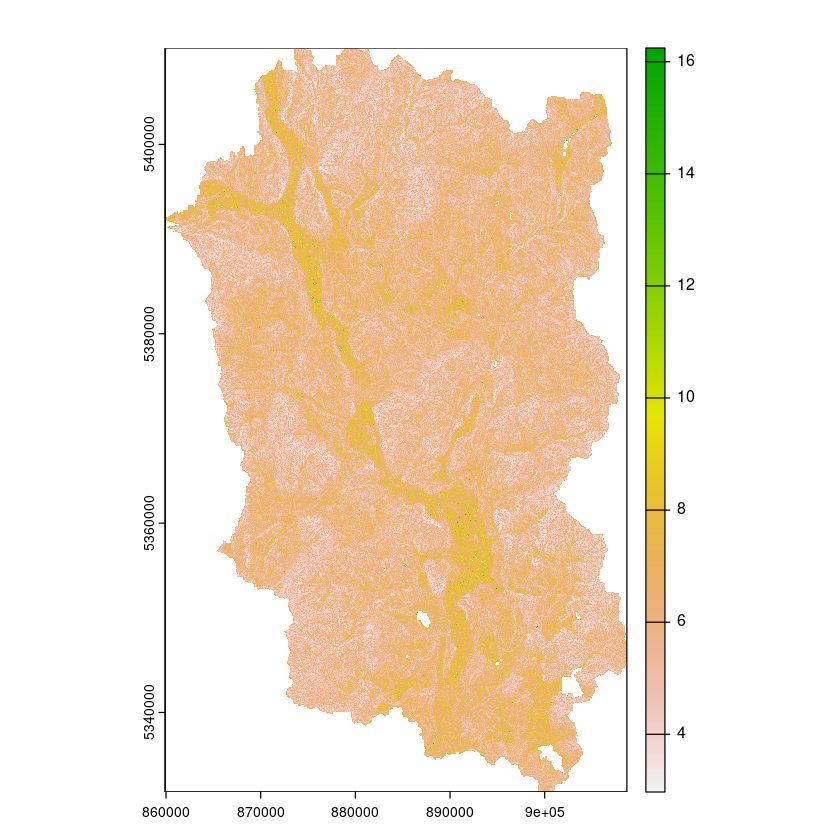

In [165]:
plot(pred_stack$wa_twi, ext = ext(vect("data/huc_data/points/Colville_pts.gpkg")))

Where:

$TWI = ln(\frac{As}{tan(Slope)})$, $As$ is the Specific Catchment Area

This may be a problem with a couple things:
1. the $tan(Slope)$ will be $0$ if $Slope = 0$
2. If $As = 0$ then the $ln(0)$ will be $-\infty$


Plotting the $ln(Slope)$ below shows us that there is indeed a problem with a 0 slope value

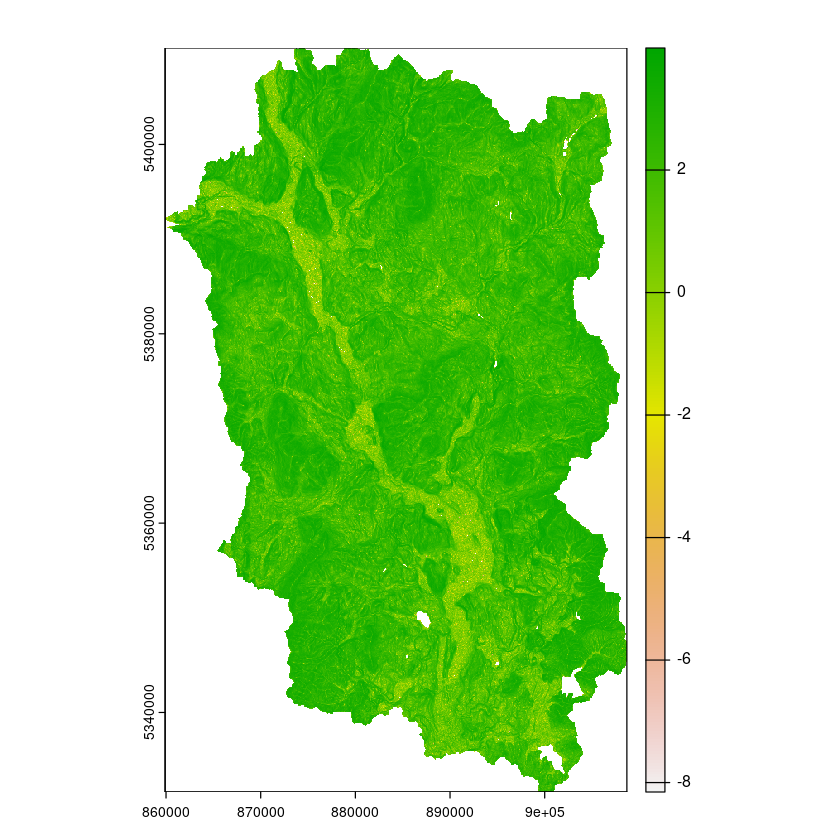

In [170]:
plot(log(pred_stack$wa_slope), ext = ext(vect("data/huc_data/points/Colville_pts.gpkg")))

In [171]:
log(0)

[1] -Inf